In [1]:
import os
import json
import csv
import random
import pickle
import cv2
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage.measurements import label

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as svc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier as RFC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, Xception, ResNet50, MobileNet
from keras.models import Model
from keras.layers import Input 
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential

from sklearn.preprocessing import StandardScaler


We are next going to import the necessary tools to use ResNet18

In [2]:
pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-c5t6csjr
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-c5t6csjr
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 772 kB/s eta 0:00:01
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20030 sha256=b23c5a98431478e41e587caa02091b3f9843f0c3e36fbc5be4b27785b7b1d453
  Stored in directory: /tmp/pip-ephem-wheel-cache-jws23ujn/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers
Note: you may need to restart the kernel to use updated packages.


In [3]:
from classification_models.keras import Classifiers

# Dataset class

In [4]:
class RefugeDataset(Dataset):

    def __init__(self, root_dir, split='train', output_size=(256,256)):
        # Define attributes
        self.output_size = output_size
        self.root_dir = root_dir
        self.split = split
        
        # Load data index
        with open(os.path.join(self.root_dir, self.split, 'index.json')) as f:
            self.index = json.load(f)
            
        self.images = []
        for k in range(len(self.index)):
            print('Loading {} image {}/{}...'.format(split, k, len(self.index)), end='\r')
            img_name = os.path.join(self.root_dir, self.split, 'images', self.index[str(k)]['ImgName'])
            img = np.array(Image.open(img_name).convert('RGB'))
            img = transforms.functional.to_tensor(img)
            img = transforms.functional.resize(img, self.output_size, interpolation=Image.BILINEAR)
            self.images.append(img)
            
        # Load ground truth for 'train' and 'val' sets
        if split != 'test':
            self.segs = []
            for k in range(len(self.index)):
                print('Loading {} segmentation {}/{}...'.format(split, k, len(self.index)), end='\r')
                seg_name = os.path.join(self.root_dir, self.split, 'gts', self.index[str(k)]['ImgName'].split('.')[0]+'.bmp')
                seg = np.array(Image.open(seg_name)).copy()
                seg = 255. - seg
                od = (seg>=127.).astype(np.float32)
                oc = (seg>=250.).astype(np.float32)
                od = torch.from_numpy(od[None,:,:])
                oc = torch.from_numpy(oc[None,:,:])
                od = transforms.functional.resize(od, self.output_size, interpolation=Image.NEAREST)
                oc = transforms.functional.resize(oc, self.output_size, interpolation=Image.NEAREST)
                seg = torch.cat([od, oc], dim=0)
                self.segs.append(seg)
                
        print('Succesfully loaded {} dataset.'.format(split) + ' '*50)
            
            
    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        # Image
        img = self.images[idx]
    
        # Return only images for 'test' set
        if self.split == 'test':
            return img
        
        # Else, images and ground truth
        else:
            # Label
            lab = torch.tensor(self.index[str(idx)]['Label'], dtype=torch.float32)

            # Segmentation masks
            seg = self.segs[idx]

            # Fovea localization
            f_x = self.index[str(idx)]['Fovea_X']
            f_y = self.index[str(idx)]['Fovea_Y']
            fov = torch.FloatTensor([f_x, f_y])
        
            return img, lab, seg, fov, self.index[str(idx)]['ImgName']

# Metrics

In [5]:
EPS = 1e-7

def compute_dice_coef(input, target):
    '''
    Compute dice score metric.
    '''
    batch_size = input.shape[0]
    return sum([dice_coef_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)])/batch_size

def dice_coef_sample(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection) / (iflat.sum() + tflat.sum())


def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.
    '''

    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=1)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter, axis=1)

    # return it
    return diameter



def vertical_cup_to_disc_ratio(od, oc):
    '''
    Compute the vertical cup-to-disc ratio from a given labelling map.
    '''
    # compute the cup diameter
    cup_diameter = vertical_diameter(oc)
    # compute the disc diameter
    disc_diameter = vertical_diameter(od)

    return cup_diameter / (disc_diameter + EPS)

def compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc):
    '''
    Compute vCDR prediction error, along with predicted vCDR and ground truth vCDR.
    '''
    pred_vCDR = vertical_cup_to_disc_ratio(pred_od, pred_oc)
    gt_vCDR = vertical_cup_to_disc_ratio(gt_od, gt_oc)
    vCDR_err = np.mean(np.abs(gt_vCDR - pred_vCDR))
    return vCDR_err, pred_vCDR, gt_vCDR


def classif_eval(classif_preds, classif_gts):
    '''
    Compute AUC classification score.
    '''
    auc = roc_auc_score(classif_gts, classif_preds)
    return auc


def fov_error(pred_fov, gt_fov):
    '''
    Fovea localization error metric (mean root squared error).
    '''
    err = np.sqrt(np.sum((gt_fov-pred_fov)**2, axis=1)).mean()
    return err

# Post-processing functions

In [6]:
def refine_seg(pred):
    '''
    Only retain the biggest connected component of a segmentation map.
    '''
    np_pred = pred.numpy()
        
    largest_ccs = []
    for i in range(np_pred.shape[0]):
        labeled, ncomponents = label(np_pred[i,:,:])
        bincounts = np.bincount(labeled.flat)[1:]
        if len(bincounts) == 0:
            largest_cc = labeled == 0
        else:
            largest_cc = labeled == np.argmax(bincounts)+1
        largest_cc = torch.tensor(largest_cc, dtype=torch.float32)
        largest_ccs.append(largest_cc)
    largest_ccs = torch.stack(largest_ccs)
    
    return largest_ccs

# Network

In [7]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.epoch = 0

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.output_layer = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out = self.up1(x5, x4)
        out = self.up2(out, x3)
        out = self.up3(out, x2)
        out = self.up4(out, x1)
        out = self.output_layer(out)
        out = torch.sigmoid(out)
        return out

    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Use the normal convolutions to reduce the number of channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    '''
    Simple convolution.
    '''
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Settings

In [8]:
root_dir = '/kaggle/input/eurecom-aml-2021-challenge-2/refuge_data/refuge_data'
lr = 1e-4
batch_size = 8
num_workers = 8
total_epoch = 100

# Create datasets and data loaders
All image files are loaded in RAM in order to speed up the pipeline. Therefore, each dataset creation should take a few minutes.

In [9]:
# Datasets
train_set = RefugeDataset(root_dir, 
                          split='train')
val_set = RefugeDataset(root_dir, 
                        split='val')
test_set = RefugeDataset(root_dir, 
                         split='test')

# Dataloaders
train_loader = DataLoader(train_set, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=num_workers,
                          pin_memory=True,
                         )
val_loader = DataLoader(val_set, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers,
                        pin_memory=True,
                        )
test_loader = DataLoader(test_set, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers,
                        pin_memory=True)

Succesfully loaded train dataset.                                                  
Succesfully loaded val dataset.                                                  
Succesfully loaded test dataset.                                                  


In [10]:
nb_train_batches = len(train_loader)
nb_val_batches = len(val_loader)

### Device, model, loss and optimizer

In [11]:
# Device
device = torch.device("cuda:0")

# Network
model = UNet(n_channels=3, n_classes=2).to(device)

# Loss
seg_loss = torch.nn.BCELoss(reduction='mean')


# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train for OC/OD segmentation

We decided to not shuffle the train data so that we can build other features for the moment outside the loop of the U-Net

In [ ]:
# Define parameters
nb_train_batches = len(train_loader)
nb_val_batches = len(val_loader)
nb_iter = 0
best_val_auc = 0.

while model.epoch < total_epoch:
    # Accumulators
    train_vCDRs, val_vCDRs = [], [] 
    train_classif_gts, val_classif_gts = [], []
    train_loss, val_loss = 0., 0.
    train_dsc_od, val_dsc_od = 0., 0.
    train_dsc_oc, val_dsc_oc = 0., 0.
    train_vCDR_error, val_vCDR_error = 0., 0.
    
    ############
    # TRAINING #
    ############
    model.train()
    train_data = iter(train_loader)
    for k in range(nb_train_batches):
        # Loads data
        imgs, classif_gts, seg_gts, fov_coords, names = train_data.next()
        imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

        # Forward pass
        logits = model(imgs)
        loss = seg_loss(logits, seg_gts)
 
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / nb_train_batches
        
        with torch.no_grad():
            # Compute segmentation metric
            pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            gt_od = seg_gts[:,0,:,:].type(torch.int8)
            gt_oc = seg_gts[:,1,:,:].type(torch.int8)
            dsc_od = compute_dice_coef(pred_od, gt_od)
            dsc_oc = compute_dice_coef(pred_oc, gt_oc)
            train_dsc_od += dsc_od.item()/nb_train_batches
            train_dsc_oc += dsc_oc.item()/nb_train_batches


            # Compute and store vCDRs
            vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
            train_vCDRs += pred_vCDR.tolist()
            train_vCDR_error += vCDR_error / nb_train_batches
            train_classif_gts += classif_gts.cpu().numpy().tolist()
            
        # Increase iterations
        nb_iter += 1
        
        # Std out
        print('Epoch {}, iter {}/{}, loss {:.6f}'.format(model.epoch+1, k+1, nb_train_batches, loss.item()) + ' '*20, 
              end='\r')
        
    # Train a logistic regression on vCDRs
    train_vCDRs = np.array(train_vCDRs).reshape(-1,1)
    train_classif_gts = np.array(train_classif_gts)
    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(train_vCDRs, train_classif_gts)
    train_classif_preds = clf.predict_proba(train_vCDRs)[:,1]
    train_auc = classif_eval(train_classif_preds, train_classif_gts)
    
    ##############
    # VALIDATION #
    ##############
    model.eval()
    with torch.no_grad():
        val_data = iter(val_loader)
        for k in range(nb_val_batches):
            # Loads data
            imgs, classif_gts, seg_gts, fov_coords, names = val_data.next()
            imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

            # Forward pass
            logits = model(imgs)
            val_loss += seg_loss(logits, seg_gts).item() / nb_val_batches

            # Std out
            print('Validation iter {}/{}'.format(k+1, nb_val_batches) + ' '*50, 
                  end='\r')
            
            # Compute segmentation metric
            pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            gt_od = seg_gts[:,0,:,:].type(torch.int8)
            gt_oc = seg_gts[:,1,:,:].type(torch.int8)
            dsc_od = compute_dice_coef(pred_od, gt_od)
            dsc_oc = compute_dice_coef(pred_oc, gt_oc)
            val_dsc_od += dsc_od.item()/nb_val_batches
            val_dsc_oc += dsc_oc.item()/nb_val_batches
            
            # Compute and store vCDRs
            vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
            val_vCDRs += pred_vCDR.tolist()
            val_vCDR_error += vCDR_error / nb_val_batches
            val_classif_gts += classif_gts.cpu().numpy().tolist()
            
            

    # Glaucoma predictions from vCDRs
    val_vCDRs = np.array(val_vCDRs).reshape(-1,1)
    val_classif_gts = np.array(val_classif_gts)
    val_classif_preds = clf.predict_proba(val_vCDRs)[:,1]
    val_auc = classif_eval(val_classif_preds, val_classif_gts)
        
    # Validation results
    print('VALIDATION epoch {}'.format(model.epoch+1)+' '*50)
    print('LOSSES: {:.4f} (train), {:.4f} (val)'.format(train_loss, val_loss))
    print('OD segmentation (Dice Score): {:.4f} (train), {:.4f} (val)'.format(train_dsc_od, val_dsc_od))
    print('OC segmentation (Dice Score): {:.4f} (train), {:.4f} (val)'.format(train_dsc_oc, val_dsc_oc))
    print('vCDR error: {:.4f} (train), {:.4f} (val)'.format(train_vCDR_error, val_vCDR_error))
    print('Classification (AUC): {:.4f} (train), {:.4f} (val)'.format(train_auc, val_auc))
    
    # Save model if best validation AUC is reached
    if val_auc > best_val_auc:
        torch.save(model.state_dict(), '/kaggle/working/best_AUC_weights.pth')
        with open('/kaggle/working/best_AUC_classifier.pkl', 'wb') as clf_file:
            pickle.dump(clf, clf_file)
        best_val_auc = val_auc
        print('Best validation AUC reached. Saved model weights and classifier.')
    print('_'*50)
        
    # End of epoch
    model.epoch += 1
        

## Getting weights of Model


We decided to save our weights fromerly computed so that we don't have to execute the U-net anymore.

In [12]:
# Load model and classifier
model = UNet(n_channels=3, n_classes=2).to(device)
model.load_state_dict(torch.load('../input/best-auc-weightspth/best_AUC_weights.pth'))

<All keys matched successfully>

## Adding Features

The first method that came to our mind to improve the accuracy was to create some features for each image and take them into account to train and use our classifier. We therefore created 26 features (some are very similar) and then tried to select the most pertinent one.

**Feature Engineering**

In [37]:
from skimage.measure import regionprops
from skimage.measure import find_contours
import skimage.morphology as morpho


def average_contrast(ori, region):
    
    """This function gives the features of the image which corresponds to the average contrast of the region
    input : ori (original image), region (segmentation)
    ouput : contrast_R, contrast_G, contrast_B the set of average contrast on every channel"""
    
    ori = np.array(ori)    #computing the gradient norm of the image
    se=morpho.selem.disk(1)
        
    contrast = []
    
    
    for i in range(len(ori)) :
        im = ori[i]
        grad = morpho.dilation(im[:,:], se)- morpho.erosion(im[:,:], se)
        
        seg = region[i]
        contrast.append(np.mean(grad[seg>0],axis=0))
       
        
    return contrast
def norm_grad(im):
    sobelx = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=5)
    return(sobelx**2 + sobely**2)**0.5

def featuresComputation(im, segCup, segDisc):
    sumN = np.sum(segDisc)
    features = []
    #  ratio and areas
    features.append(np.sum(segCup))
    features.append(np.sum(segDisc))
    features.append(np.sum(segDisc)/np.sum(segCup))
    
    # relative position
    cCup = regionprops(segCup)[0].centroid
    if sumN!=0:
        cDisc = regionprops(segDisc)[0].centroid
    else:
        cDisc = (0,0)
    features.append(cCup[0]-cDisc[0])  # decalage en x
    features.append(cCup[1]-cDisc[1])  # decalage en y
    
    # eccentricity
    features.append(regionprops(segCup)[0].eccentricity)
    if sumN !=0:
        features.append(regionprops(segDisc)[0].eccentricity)
    else :
        features.append(0)
    
    # major_axis_length
    features.append(regionprops(segCup)[0].major_axis_length)
    if sumN !=0:
        features.append(regionprops(segDisc)[0].major_axis_length)
    else :
        features.append(0)
    
    # minor_axis_length
    features.append(regionprops(segCup)[0].minor_axis_length)
    if sumN !=0:
        features.append(regionprops(segDisc)[0].minor_axis_length)
    else :
        features.append(0)
    
    # perimeter
    features.append(regionprops(segCup)[0].perimeter)
    if sumN !=0:
        features.append(regionprops(segDisc)[0].perimeter)
    else :
        features.append(0)
    
    # orientation
    features.append(regionprops(segCup)[0].orientation)
    if sumN !=0:
        features.append(regionprops(segDisc)[0].orientation)
    else :
        features.append(0)
    
    if sumN !=0:
        contours_Cup = find_contours(segCup,0.5)
        contours_Disc = find_contours(segDisc,0.5)
        tension1 = np.gradient(contours_Cup[0],axis=0)
        tension2 = np.gradient(contours_Disc[0],axis=0)
        features.append(np.abs(tension1).mean())
        features.append(np.abs(tension2).mean())
    
        courbure1 = np.gradient(tension1,axis=0)
        courbure2 = np.gradient(tension2,axis=0)
        features.append(np.abs(courbure1).mean())
        features.append(np.abs(courbure2).mean())
    else : 
        features.append(0)
        features.append(0)
        features.append(0)
        features.append(0)
    
    
    
    # average intensity
    av_Cup = (im*segCup).mean()
    av_Disc = (im*segDisc).mean()
    features.append(av_Cup)
    features.append(av_Disc)
        
    # standard deviation 
    std_Cup = (im*segCup).std()
    std_Disc = (im*segDisc).std()
    features.append(std_Cup)
    features.append(std_Disc)
        
    # gradient
    grad_Cup = norm_grad(im*segCup).mean()
    grad_Disc = norm_grad(im*segDisc).mean()
    features.append(grad_Cup)
    features.append(grad_Disc)        
        
    return features


Now that we have functions that can compute the wanted features we apply it to the dataset in order to train the classifier with them.


In [38]:
import matplotlib.pyplot as plt
#Computing the right VCDRs (with the good weight)
train_vCDRs = []
train_classif_gts = []
train_loss = 0.
train_dsc_od = 0.
train_dsc_oc = 0.
train_vCDR_error = 0.

Contrast = []

FeaturesList = []

with torch.no_grad():
    train_data = iter(train_loader)
    for k in range(nb_train_batches):
    
            # Loads data
            imgs, classif_gts, seg_gts, fov_coords, names = train_data.next()
            imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)
            logits = model(imgs)
            
            # Compute segmentation metric
            pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            gt_od = seg_gts[:,0,:,:].type(torch.int8)
            gt_oc = seg_gts[:,1,:,:].type(torch.int8)
            dsc_od = compute_dice_coef(pred_od, gt_od)
            dsc_oc = compute_dice_coef(pred_oc, gt_oc)
            train_dsc_od += dsc_od.item()/nb_val_batches
            train_dsc_oc += dsc_oc.item()/nb_val_batches
            
            # Compute and store vCDRs
            vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
            train_vCDRs += pred_vCDR.tolist()
            train_vCDR_error += vCDR_error / nb_val_batches
            train_classif_gts += classif_gts.cpu().numpy().tolist()
            
            
            # Computing the contrast Feature
            
            imgs = imgs.cpu()
            logits = logits.cpu()

            ctrs = average_contrast(imgs[:,0,:,:],logits[:,0,:,:])    
            Contrast += ctrs
            # Computing the other features
            features = []
            for i in range (8):
                features.append(featuresComputation(imgs[i,0,:,:].numpy(), (logits[i,1,:,:].numpy()>0.1).astype(int), (logits[i,0,:,:].numpy()>0.1).astype(int)))
            FeaturesList += features

Then we combine every features in the same array and make a DataFrame for readability and analysis. We need to select the most pertinent feature. (too much feature is no good for our accuracy)


In [39]:
FeaturesList = np.array(FeaturesList).reshape(-1,25)
train_vCDRs = np.array(train_vCDRs).reshape(-1,1)
Contrast = np.array(Contrast).reshape(-1,1)
features2 = np.concatenate((train_vCDRs,Contrast),axis=1)
featuresAll = np.concatenate((train_vCDRs,Contrast,FeaturesList),axis=1)

FeatureNames = ['VCDR','Contrast','SumCup','SumDisc','RationSum','X_Gap','y_Gap','Cup_Ecc','Disc_Ecc','Major_Axis_Cup','Major_axis_Disc','Minor_axis_Cup','Minor_axis_disk','Perimeter_cup','Perimeter_Disk','Orientation_Cup','Orientation_Disk','Tenstion_cup','Tension_disk','Courbure_cup','Courbure_disk','av_Cup','av_Disk','std_cup','std_Disk','gradient_cup','gradient_Disk','Label']

Table = pd.DataFrame(np.concatenate((featuresAll,np.array(train_classif_gts).reshape(-1,1)),axis=1),columns=FeatureNames)

print(Table.head())

       VCDR  Contrast  SumCup  SumDisc  RationSum     X_Gap     y_Gap  \
0  0.659091  0.025032   603.0   1395.0   2.313433 -0.337902 -0.189590   
1  0.794872  0.026834   727.0   1012.0   1.392022  1.302692 -0.097307   
2  0.735294  0.026927   526.0    888.0   1.688213  0.300196 -0.751927   
3  0.636364  0.030969   338.0    811.0   2.399408  0.219256  0.538046   
4  0.487805  0.038205   355.0   1218.0   3.430986  1.111053  3.595819   

    Cup_Ecc  Disc_Ecc  Major_Axis_Cup  ...  Tension_disk  Courbure_cup  \
0  0.435034  0.463838       29.215415  ...           0.5      0.081081   
1  0.480473  0.551361       32.502602  ...           0.5      0.082000   
2  0.242315  0.243012       26.276880  ...           0.5      0.082524   
3  0.315244  0.381241       21.293367  ...           0.5      0.072289   
4  0.140221  0.506395       21.361879  ...           0.5      0.079412   

   Courbure_disk    av_Cup   av_Disk   std_cup  std_Disk  gradient_cup  \
0       0.093567  0.008109  0.016099  0.08

**Feature Selection**

In this case we have a numerical input, categorical output. This is a classification predictive modeling problem with numerical input variables. Again, the most common techniques are correlation based, although in this case, they must take the categorical target into account.

Because of this we decided to use ANOVA correlation coefficient (linear) and the mutual information.

Let's use Anova -f from sklearn:

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


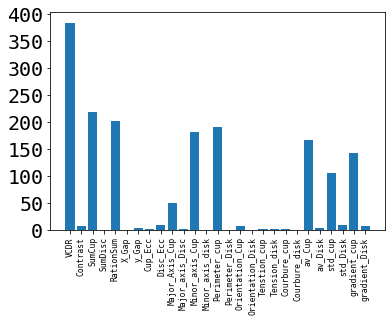

In [40]:
# configure to select all features
fs = feature_selection.SelectKBest(k='all')

X_train = Table[['VCDR','Contrast','SumCup','SumDisc','RationSum','X_Gap','y_Gap','Cup_Ecc','Disc_Ecc','Major_Axis_Cup','Major_axis_Disc','Minor_axis_Cup','Minor_axis_disk','Perimeter_cup','Perimeter_Disk','Orientation_Cup','Orientation_Disk','Tenstion_cup','Tension_disk','Courbure_cup','Courbure_disk','av_Cup','av_Disk','std_cup','std_Disk','gradient_cup','gradient_Disk']]
y_train = np.array(Table['Label']).reshape(-1,1)
# learn relationship from training data
fs.fit(X_train,y_train)

# plot the scores
plt.bar(['VCDR','Contrast','SumCup','SumDisc','RationSum','X_Gap','y_Gap','Cup_Ecc','Disc_Ecc','Major_Axis_Cup','Major_axis_Disc','Minor_axis_Cup','Minor_axis_disk','Perimeter_cup','Perimeter_Disk','Orientation_Cup','Orientation_Disk','Tenstion_cup','Tension_disk','Courbure_cup','Courbure_disk','av_Cup','av_Disk','std_cup','std_Disk','gradient_cup','gradient_Disk'], fs.scores_)
plt.xticks(rotation=90,fontsize=8, fontname='monospace')
plt.yticks(fontsize=20, fontname='monospace')
plt.show()

This clearly shows that feature VCDRs / SumCup / Major_Axis_Cup / Minor_axis_Cup / Perimeter_Cup /av_cup / std_cup / gradient_cup might be the most relevant (according to test) and that perhaps six of the eight input features are the more relevant.

Let's compute **the mutual information** to confirm our result from adova. The scikit-learn machine learning library provides an implementation of mutual information for feature selection with numeric input and categorical output variables via the mutual_info_classif() function.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


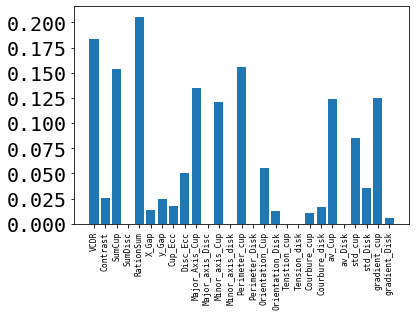

In [41]:
 # configure to select all features
fs = feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)

# plot the scores
plt.bar(['VCDR','Contrast','SumCup','SumDisc','RationSum','X_Gap','y_Gap','Cup_Ecc','Disc_Ecc','Major_Axis_Cup','Major_axis_Disc','Minor_axis_Cup','Minor_axis_disk','Perimeter_cup','Perimeter_Disk','Orientation_Cup','Orientation_Disk','Tenstion_cup','Tension_disk','Courbure_cup','Courbure_disk','av_Cup','av_Disk','std_cup','std_Disk','gradient_cup','gradient_Disk'], fs.scores_)
plt.xticks(rotation=90,fontsize=8, fontname='monospace')
plt.yticks(fontsize=20, fontname='monospace')
plt.show()

This confirms the selection of feature that ADOVA gave. 

We now need to select a combinaison of those that gives us the best results. We didn't find any other way than the very simple empiric way of testing with several combinaison. The results on the validation set are at the end of this notebook.

In [42]:
# We test different combinaison of features (from the ones with some correlation)

#a simple pre-precessing step
X_scaler = StandardScaler().fit(featuresAll)
featuresAll = X_scaler.transform(featuresAll)

selectedFeatures1 = featuresAll[:,(0,2,4,9,11,13)]
selectedFeatures2 = featuresAll[:,(0,2,4,9,11,13,21,23,25)]

## Classifier

We decided to separate the feature extraction and the classification so that we have a clearer way of introducing new 
features to the process. We are training several classifier to compare the results.



In [43]:
# Train a logistic regression on vCDRs with the good weight
train_classif_gts = np.array(train_classif_gts).reshape(-1,1)
train_vCDRs =  np.array(train_vCDRs).reshape(-1,1)
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(train_vCDRs, train_classif_gts)
train_classif_preds = clf.predict_proba(train_vCDRs)[:,1]

        

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [44]:
# Train a logistic regression with the selected features

clf2 = LogisticRegression(random_state=0, solver='lbfgs').fit(selectedFeatures1, train_classif_gts)

clf3 = LogisticRegression(random_state=0, solver='lbfgs').fit(selectedFeatures2, train_classif_gts)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The result aren't that encouraging when using logistic regression on a selection of features. Let's try to use random forest, this model is very transparent an would give us information on where to improve our features.

In [45]:
rfc1 = RFC(random_state=0)
rfc1.fit(selectedFeatures1,train_classif_gts)

rfc2 = RFC(random_state=0)
rfc2.fit(selectedFeatures2,train_classif_gts)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(random_state=0)

The results of the classifier will be compared when testing on the validation set, after trying the second method. The goal is two compare the two ways we designed.

## Let's try a CNN directly on the picture 

Glaucoma displays its main clinical symptoms in the optic disc region. Based on this mechanism, with optic disc segmentation predictions, we first crop the regions of interest and resize the patches to size 60*60 to exclude irrelevant
background contexts. 

In order to improve our results we use Histogram equalization, CLAHE, for contrast enhancement
and normalization so that even though the images are not taken in the exact same condition it should be processed correclty as a whole. 

The image are therefore enhanced and way smaller so they can be processed by a CNN directly.


In [13]:
pip install progressbar

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12075 sha256=490333b8c7574168695ac030d449516b14f2d6d8ccd7168e1d9091f5e02e897b
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar
Note: you may need to restart the kernel to use updated packages.


In [14]:
import matplotlib.pyplot as plt
import cv2
from progressbar import ProgressBar
pbar = ProgressBar()

# create a CLAHE object .
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

imagesTrain = []
sick_vector_train = []
threshold = 0.5

with torch.no_grad():
    train_data = iter(train_loader)
    for k in pbar(range(nb_train_batches)):
        # Loads data
        imgs, classif_gts, seg_gts, fov_coords, names = train_data.next()
        imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

        logits = model(imgs)

        imgs = imgs.cpu()
        logits = logits.cpu()
        masks = np.array(refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8)))
        for p in range (len(imgs[:,0,:,:])):
            x = []
            y = []
            mask = masks[p]
            sick_vector_train.append(classif_gts[p].item())
            for i in range (mask.shape[0]):
                for j in range (mask.shape[1]):
                    if mask[i][j]>threshold:
                        x.append(i)
                        y.append(j)
                       
            imga = imgs[p,:,:,:].numpy()[:,max(round(np.mean(x))-30,0):min(round(np.mean(x))+30,256),max(round(np.mean(y))-30,0):min(round(np.mean(y))+30,256)]
            
            
             #Let's resize those that weren't well done 
            if(imga.shape) != (3,60, 60):
                image = np.zeros((3,60,60))
                for idx in range(len(imga)):
                    img = imga[idx, :, :]
                    img_sm = cv2.resize(img, (60, 60), interpolation=cv2.INTER_CUBIC)
                    image[idx, :, :] = img_sm
                imga = image
            
            #that allows to have the dimension in the right order !
            imae = np.zeros((60,60,3))
            for i in range(3):
                imae[:,:,i] = clahe.apply((imga[i,:,:]*255).astype(np.uint8))
                
            imagesTrain.append(np.array(imae))

100% |########################################################################|


In [15]:
## Let's do the same with the validation data 
pbar = ProgressBar()

imagesVal = []
sick_vector_Val = []
with torch.no_grad():
    val_data = iter(val_loader)
    for k in pbar(range(nb_val_batches)):
        # Loads data
        imgs, classif_gts, seg_gts, fov_coords, names = val_data.next()
        imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

        logits = model(imgs)

        imgs = imgs.cpu()
        logits = logits.cpu()
        masks = np.array(refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8)))
        for p in range (len(imgs[:,0,:,:])):
            x = []
            y = []
            mask = masks[p]
            sick_vector_Val.append(classif_gts[p].item())
            for i in range (mask.shape[0]):
                for j in range (mask.shape[1]):
                    if mask[i][j]>threshold:
                        x.append(i)
                        y.append(j)
                       
          
            imga = imgs[p,:,:,:].numpy()[:,max(round(np.mean(x))-30,0):min(round(np.mean(x))+30,256),max(round(np.mean(y))-30,0):min(round(np.mean(y))+30,256)]
            
            
            
            
            #Let's resize those that weren't well done 
            if(imga.shape) != (3,60, 60):
                image = np.zeros((3,60,60))
                for idx in range(len(imga)):
                    img = imga[idx, :, :]
                    img_sm = cv2.resize(img, (60, 60), interpolation=cv2.INTER_CUBIC)
                    image[idx, :, :] = img_sm
                imga = image
            

            #that allows to have the dimension in the right order !
            imae = np.zeros((60,60,3))
            for i in range(3):
                #We apply the histogram equalization CLAHE
                imae[:,:,i] = clahe.apply((imga[i,:,:]*255).astype(np.uint8))

                    
            imagesVal.append(np.array(imae))


100% |########################################################################|


Note : We wanted to use the high resolution image and then apply to it the segmentation mask but getting the real image means having another dimensions and therefore the mask won't work on the high resolution image.

Now that we have the right images (focused on the usefull zone) we are going to pre-process it so that it can bu use in several neural-networks.

In [16]:
sick_vector_Train = np.array(sick_vector_train).reshape(-1,1)
imagesTrain=np.array(imagesTrain)
X_train_cnn = imagesTrain.reshape(imagesTrain.shape[0], 60, 60, 3)

sick_vector_Val = np.array(sick_vector_Val).reshape(-1,1)
imagesVal=np.array(imagesVal)
X_val_cnn = imagesVal.reshape(imagesVal.shape[0], 60, 60, 3)


To improve the performance of the models we decided to use a part of the validation set to train the models.
So now we have the training and validation set to train and we took out a 100 images out of the validation set 
to validate.

In [17]:
#Let's create the new training set
new_sick_vector_Train = np.concatenate((sick_vector_Train,sick_vector_Val[-250:]),axis=0)
new_Xtrain_cnn = np.concatenate((X_train_cnn,X_val_cnn[-250:]),axis=0)



#Let's create the new validation set 

new_sick_vector_Val = sick_vector_Val[:150]
new_Xval_cnn = X_val_cnn[:150]



We decided to use Data Augmentation : We are creating some images from the ones we have in order to improve the accuracy of our models. Those tools also allows to have the right format input objects for our Keras nets.


In [18]:
# All images will be rescaled by 1./255. , the rest should prevent from overfitting, since we are using a small data set it can
#be a problem
train_datagen = ImageDataGenerator( rescale = 1.0/255.,rotation_range = 40,width_shift_range=0.2,height_shift_range=0.2,
                                  shear_range=0.2,zoom_range=0.2)
# --------------------
# Flow training images in batches of batch_size using train_datagen generator
# --------------------
train_generator = train_datagen.flow(new_Xtrain_cnn,new_sick_vector_Train,batch_size=batch_size)

# All images will be rescaled by 1./255.
val_datagen = ImageDataGenerator( rescale = 1.0/255.)
# --------------------
# Flow training images in batches of batch_size using train_datagen generator
# --------------------
val_generator =  val_datagen.flow(new_Xval_cnn,new_sick_vector_Val,batch_size=batch_size)

**Now let's try several neural net**

Our goal is to try a few nets and compare the results to select the most suited one.

**The first one is a simple homemade CNN**

In [49]:
model_cnn2 = Sequential()
model_cnn2.add(layers.Conv2D(input_shape=(60,60,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_cnn2.add(layers.BatchNormalization())
model_cnn2.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_cnn2.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_cnn2.add(layers.BatchNormalization())
model_cnn2.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_cnn2.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_cnn2.add(layers.BatchNormalization())
model_cnn2.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_cnn2.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_cnn2.add(layers.BatchNormalization())
model_cnn2.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_cnn2.add(layers.Flatten())
model_cnn2.add(layers.Dense(units=1024,activation="relu"))
model_cnn2.add(layers.Dense(units=1024,activation="relu"))
model_cnn2.add(layers.Dense(units=1, activation="sigmoid"))

# Compiling the CNN
model_cnn2.compile(loss = 'binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics = ['acc'])


#Saving the best model

checkpoint_path = "./modelCnn.h5"


cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only = True)
model_cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 60, 60, 64)        1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 256)      

Epoch 1/30
82/82 [==============================] - 5s 20ms/step - loss: 0.6276 - acc: 0.8758 - val_loss: 0.8488 - val_acc: 0.1000

Epoch 00001: val_loss improved from inf to 0.84876, saving model to ./modelCnn.h5
Epoch 2/30
82/82 [==============================] - 1s 12ms/step - loss: 0.3170 - acc: 0.8862 - val_loss: 0.8914 - val_acc: 0.1000

Epoch 00002: val_loss did not improve from 0.84876
Epoch 3/30
82/82 [==============================] - 1s 12ms/step - loss: 0.2440 - acc: 0.9129 - val_loss: 1.1983 - val_acc: 0.1000

Epoch 00003: val_loss did not improve from 0.84876
Epoch 4/30
82/82 [==============================] - 1s 12ms/step - loss: 0.2895 - acc: 0.9230 - val_loss: 0.8217 - val_acc: 0.2667

Epoch 00004: val_loss improved from 0.84876 to 0.82168, saving model to ./modelCnn.h5
Epoch 5/30
82/82 [==============================] - 1s 12ms/step - loss: 0.2657 - acc: 0.9111 - val_loss: 1.0240 - val_acc: 0.2200

Epoch 00005: val_loss did not improve from 0.82168
Epoch 6/30
82/82 [=

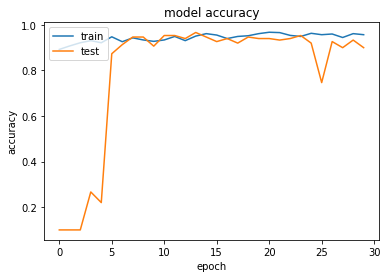

In [20]:
history = model_cnn2.fit(train_generator, validation_data = val_generator, epochs=30, verbose=1,callbacks = [cp_callback])

,
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_cnn2.load_weights('modelCnn.h5')
model_cnn2.evaluate(new_Xtest_cnn, new_sick_vector_Test)
test_classif_preds = model_cnn2.predict(new_X_val_cnn)
val_aucCnn = classif_eval(test_classif_preds, new_sick_vector_Test)
print('The AUC score value is :',val_aucCnn)

**Comment**

This model gives us pretty a very good AUC. What we notice is that we had to find a balance in the complexity of the model. Too much layers created a very important overfitting phenomenon. (That's actually what's happening for the resNet).

We also notice that the model with the best val_accuracy isn't the one that generalize the best, maybe that's because we use a large part of the validation set to train and therefor the result are better for some weights. (to explore)

**We also tried a pre-trained one, ResNet18 :** 

ResNet18 is a 18 layers deep model, so the process time is short, and according to what we read is very suited for image classification like the one we do here.

In [50]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
modelResNet18 = ResNet18((60, 60, 3), weights='imagenet')

for layer in modelResNet18.layers[:]:
    layer.trainable = False
    
modelRes = Sequential()
modelRes.add(modelResNet18)
modelRes.add(layers.BatchNormalization())
modelRes.add(layers.Flatten())
modelRes.add(layers.Dense(units=1024,activation="relu"))
modelRes.add(layers.Dense(units=1024,activation="relu"))
modelRes.add(layers.Dense(units=1, activation="sigmoid"))

modelRes.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-6),metrics=["accuracy"])

Epoch 1/15
82/82 [==============================] - 3s 22ms/step - loss: 0.6928 - accuracy: 0.8612 - val_loss: 0.6916 - val_accuracy: 0.9000
Epoch 2/15
82/82 [==============================] - 1s 13ms/step - loss: 0.6914 - accuracy: 0.8881 - val_loss: 0.6901 - val_accuracy: 0.9000
Epoch 3/15
82/82 [==============================] - 1s 13ms/step - loss: 0.6897 - accuracy: 0.8825 - val_loss: 0.6880 - val_accuracy: 0.9000
Epoch 4/15
82/82 [==============================] - 1s 13ms/step - loss: 0.6871 - accuracy: 0.9137 - val_loss: 0.6854 - val_accuracy: 0.9000
Epoch 5/15
82/82 [==============================] - 1s 13ms/step - loss: 0.6847 - accuracy: 0.9000 - val_loss: 0.6823 - val_accuracy: 0.9000
Epoch 6/15
82/82 [==============================] - 1s 13ms/step - loss: 0.6818 - accuracy: 0.8911 - val_loss: 0.6787 - val_accuracy: 0.9000
Epoch 7/15
82/82 [==============================] - 1s 13ms/step - loss: 0.6772 - accuracy: 0.9160 - val_loss: 0.6745 - val_accuracy: 0.9000
Epoch 8/15
82

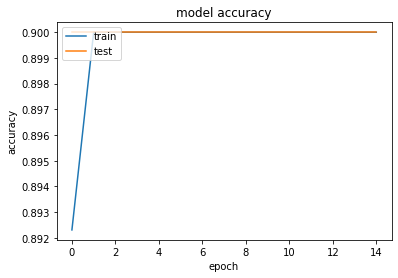

In [51]:
historyRes = modelRes.fit(train_generator, validation_data = val_generator, epochs=15, verbose=1,batch_size=8)

plt.plot(historyRes.history['accuracy'])
plt.plot(historyRes.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


**Performance Comments**



What we think is happening here is an important overfitting, that seems to explain why the val_accuracy doesn't change.
To prevent that we tried adding batchNormalization et use the imageGenerator tool but we haven't been able to avoid this problem. We would need more data to train the resNet. 


# Check performance is maintained on validation

In [52]:
model.eval()
val_vCDRs = []
val_classif_gts = []
val_loss = 0.
val_dsc_od = 0.
val_dsc_oc = 0.
val_vCDR_error = 0.
feature2 = []
FeaturesList = []
imagesCroppedVal = []

# create a CLAHE object .
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

with torch.no_grad():
    val_data = iter(val_loader)
    for k in range(nb_val_batches):
        # Loads data
        imgs, classif_gts, seg_gts, fov_coords, names = val_data.next()
        imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

        # Forward pass
        logits = model(imgs)
        val_loss += seg_loss(logits, seg_gts).item() / nb_val_batches

        # Std out
        print('Validation iter {}/{}'.format(k+1, nb_val_batches) + ' '*50, 
              end='\r')

        # Compute segmentation metric
        pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
        pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
        
        gt_od = seg_gts[:,0,:,:].type(torch.int8)
        gt_oc = seg_gts[:,1,:,:].type(torch.int8)
        dsc_od = compute_dice_coef(pred_od, gt_od)
        dsc_oc = compute_dice_coef(pred_oc, gt_oc)
        val_dsc_od += dsc_od.item()/nb_val_batches
        val_dsc_oc += dsc_oc.item()/nb_val_batches

        # Compute and store vCDRs
        vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
        val_vCDRs += pred_vCDR.tolist()
        val_vCDR_error += vCDR_error / nb_val_batches
        val_classif_gts += classif_gts.cpu().numpy().tolist()
        
        
        logits = model(imgs)
        imgs = imgs.cpu()
        logits = logits.cpu()
        
        contrast = average_contrast(imgs[:,0,:,:],logits[:,0,:,:])    
        feature2 += contrast
        
        features = []
    
        for i in range (8):
            features.append(featuresComputation(imgs[i,0,:,:].numpy(), (logits[i,0,:,:].numpy()>0.1).astype(int), (logits[i,1,:,:].numpy()>0.1).astype(int)))
        FeaturesList += features
        
        
        #Now the CNN method
        
        masks = np.array(refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8)))
        for p in range (len(imgs[:,0,:,:])):
            x = []
            y = []
            mask = masks[p]
            
            for i in range (mask.shape[0]):
                for j in range (mask.shape[1]):
                    if mask[i][j]>threshold:
                        x.append(i)
                        y.append(j)
                       
            imga = imgs[p,:,:,:].numpy()[:,max(round(np.mean(x))-30,0):min(round(np.mean(x))+30,256),max(round(np.mean(y))-30,0):min(round(np.mean(y))+30,256)]
            
            
             #Let's resize those that weren't well done 
            if(imga.shape) != (3,60, 60):
                image = np.zeros((3,60,60))
                for idx in range(len(imga)):
                    img = imga[idx, :, :]
                    img_sm = cv2.resize(img, (60, 60), interpolation=cv2.INTER_CUBIC)
                    image[idx, :, :] = img_sm
                imga = image
            
            #that allows to have the dimension in the right order !
            imae = np.zeros((60,60,3))
            for i in range(3):
                imae[:,:,i] = clahe.apply((imga[i,:,:]*255).astype(np.uint8))
                
            imagesCroppedVal.append(np.array(imae))
            
            
imagesCroppedVal=np.array(imagesCroppedVal)
X_cnn = imagesCroppedVal.reshape(imagesCroppedVal.shape[0], 60, 60, 3)

model_cnn2.load_weights('modelCnn.h5')
preds_cnn2 = model_cnn2.predict(X_cnn)
val_aucCnn  = classif_eval(preds_cnn2.reshape(1,-1)[0], val_classif_gts)
        
preds_Res = modelRes.predict(X_cnn)
val_aucRes  = classif_eval(preds_Res.reshape(1,-1)[0], val_classif_gts)
        
        
        
feature2 = np.array(feature2).reshape(-1,1)
val_vCDRs = np.array(val_vCDRs).reshape(-1,1)
FeaturesList = np.array(FeaturesList).reshape(-1,25)

#Then we concatenate them to have one table of features
features2 = np.concatenate((val_vCDRs,feature2),axis=1)
featuresAll = np.concatenate((features2,FeaturesList),axis=1)
featuresAll = X_scaler.transform(featuresAll)

#And we select the ones usefull
selectedFeatures1 = featuresAll[:,(0,2,4,9,11,13)]
selectedFeatures2 = featuresAll[:,(0,2,4,9,11,13,21,23,25)]
        
# Glaucoma predictions from vCDRs

val_classif_gts = np.array(val_classif_gts)

val_classif_preds = clf.predict_proba(val_vCDRs)[:,1]
val_auc = classif_eval(val_classif_preds, val_classif_gts)

val_classif_preds2 = clf2.predict_proba(selectedFeatures1)[:,1]
val_auc2 = classif_eval(val_classif_preds2, val_classif_gts)

val_classif_preds3 = clf3.predict_proba(selectedFeatures2)[:,1]
val_auc3 = classif_eval(val_classif_preds3, val_classif_gts)


# Let's try the RFC

val_classif_preds_RFC_1 = rfc1.predict_proba(selectedFeatures1)[:,1]
val_auc_rfc_1 = classif_eval(val_classif_preds_RFC_1, val_classif_gts)

val_classif_preds_RFC_2 = rfc2.predict_proba(selectedFeatures2)[:,1]
val_auc_rfc_2  = classif_eval(val_classif_preds_RFC_2, val_classif_gts)


# Validation results
print('VALIDATION '+' '*50)
print('LOSSES: {:.4f} (val)'.format(val_loss))
print('OD segmentation (Dice Score): {:.4f} (val)'.format(val_dsc_od))
print('OC segmentation (Dice Score): {:.4f} (val)'.format(val_dsc_oc))
print('vCDR error: {:.4f} (val)'.format(val_vCDR_error))
print('Classification (AUC) with vCDRs: {:.4f} (val)'.format(val_auc))

VALIDATION                                                             
LOSSES: 0.0106 (val)
OD segmentation (Dice Score): 0.9183 (val)
OC segmentation (Dice Score): 0.8373 (val)
vCDR error: 0.2198 (val)
Classification (AUC) with vCDRs: 0.8873 (val)


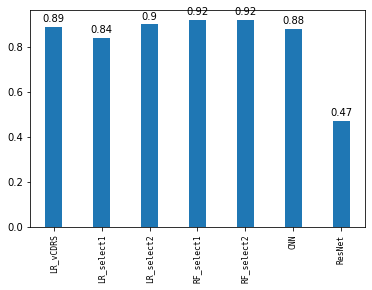

In [53]:
# Let's plot the results of our different methods
Results = [val_auc,val_auc2,val_auc3,val_auc_rfc_1,val_auc_rfc_2,val_aucCnn,val_aucRes]
labels = ["LR_vCDRS", "LR_select1", "LR_select2", "RF_select1", "RF_select2", "CNN", "ResNet"]

width = 0.35  # the width of the bars
rects1 = plt.bar(labels, np.round(Results,2), width)
plt.xticks(rotation=90,fontsize=8, fontname='monospace')
plt.bar_label(rects1, padding=3)
plt.show()

**Results Comment:**

What we see here is that no combination of features beats the use of vCDRs alone. We have tried a lot of combinaison from 25 features but every time the AUC goes down.
We tried using the random forst classifier but it also fails to push the accuracy up. 
What we concluded of this results is that there is few data to train correctly those models (400 inputs) so the models don't generalize correctly.

We have another method using CNN direclty on the zone of interest and we believe that this second method have much more potential than the classic use of features.



# Predictions on test set

In [36]:
nb_test_batches = len(test_loader)
model.eval()
test_vCDRs = []
feature = []
imagesCroppedTest = []

# create a CLAHE object .
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

with torch.no_grad():
    test_data = iter(test_loader)
    for k in range(nb_test_batches):
        # Loads data
        imgs = test_data.next()
        imgs = imgs.to(device)

        # Forward pass
        logits = model(imgs)
        

        # Std out
        print('Test iter {}/{}'.format(k+1, nb_test_batches) + ' '*50, 
              end='\r')
            
        # Compute segmentation
        pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
        pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            
        # Compute and store vCDRs
        pred_vCDR = vertical_cup_to_disc_ratio(pred_od.cpu().numpy(), pred_oc.cpu().numpy())
        test_vCDRs += pred_vCDR.tolist()
        
        imgs = imgs.cpu()
        logits = logits.cpu()
        
        masks = np.array(refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8)))
        for p in range (len(imgs[:,0,:,:])):
            x = []
            y = []
            mask = masks[p]
            
            for i in range (mask.shape[0]):
                for j in range (mask.shape[1]):
                    if mask[i][j]>threshold:
                        x.append(i)
                        y.append(j)
                       
            imga = imgs[p,:,:,:].numpy()[:,max(round(np.mean(x))-30,0):min(round(np.mean(x))+30,256),max(round(np.mean(y))-30,0):min(round(np.mean(y))+30,256)]
            
            
             #Let's resize those that weren't well done 
            if(imga.shape) != (3,60, 60):
                image = np.zeros((3,60,60))
                for idx in range(len(imga)):
                    img = imga[idx, :, :]
                    img_sm = cv2.resize(img, (60, 60), interpolation=cv2.INTER_CUBIC)
                    image[idx, :, :] = img_sm
                imga = image
            
            #that allows to have the dimension in the right order !
            imae = np.zeros((60,60,3))
            for i in range(3):
                imae[:,:,i] = clahe.apply((imga[i,:,:]*255).astype(np.uint8))
                
            imagesCroppedTest.append(np.array(imae))
            
            
    imagesCroppedTest=np.array(imagesCroppedTest)
    X_cnn = imagesCroppedTest.reshape(imagesCroppedTest.shape[0], 60, 60, 3)
            
    model_cnn2.load_weights('modelCnn.h5')
    test_classif_preds = model_cnn2.predict(X_cnn)
    
    #Glaucoma predictions from vCDRs
    #test_vCDRs = np.array(test_vCDRs).reshape(-1,1)
    #features = np.concatenate((test_vCDRs,feature2),axis=1)
    #test_classif_preds = clf2.predict_proba(features)[:,1]
    
# Prepare and save .csv file
def create_submission_csv(prediction, submission_filename='/kaggle/working/submission3.csv'):
    """Create a sumbission file in the appropriate format for evaluation.

    :param
    prediction: list of predictions (ex: [0.12720, 0.89289, ..., 0.29829])
    """
    
    with open(submission_filename, mode='w') as csv_file:
        fieldnames = ['Id', 'Predicted']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()

        for i, p in enumerate(prediction):
            
            writer.writerow({'Id': "T{:04d}".format(i+1), 'Predicted': '{:f}'.format(p)})

create_submission_csv(test_classif_preds.reshape(1,-1)[0])

# The submission.csv file is under /kaggle/working/submission.csv.
# If you want to submit it, you should download it before closing the current kernel.

0.0t iter 50/50                                                  
6.0176015e-31
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.18386385
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.4818355e-28
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.8443324e-12
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
2.2990089e-29
0.0
0.15644509
0.0
4.4905396e-10
1.0
0.0
1.9290578e-06
0.0
0.0
0.0
0.0
1.0
0.0
0.0
9.448952e-21
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.99999976
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
4.9211912e-32
1.0
0.9999927
2.8215512e-26
1.0
0.0
0.0
0.0
3.872682e-10
0.0
0.0
0.0
3.3298505e-07
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.010090872
2.4464345e-35
1.2486426e-12
0.0